# Import dữ liệu

In [1]:
# 1. Import thư viện
# -------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# graphviz python API
import graphviz

RND = 42
np.random.seed(RND)

# Đọc dữ lệu

In [2]:
df = pd.read_csv("master_data.csv") 

# Chuẩn bị dữ liệu

## Tạo biến thể tích

In [3]:
# Cần fillna(0) hoặc fillna(trung bình) để tránh lỗi nhân với Null
df['product_volume_cm3'] = (
    df['product_length_cm'].fillna(0) * df['product_height_cm'].fillna(0) * df['product_width_cm'].fillna(0)
)

In [4]:
potential_features = [
    'price', 'freight_value', 'delivery_days', 'is_late',
    'product_weight_g', 'product_volume_cm3', 'payment_value_sum', 'payment_count'
]
features = [c for c in potential_features if c in df.columns]
target = 'review_binary'

In [5]:
# 3. Loại bỏ hàng không có target
# -------------------------
df = df.dropna(subset=[target])
X = df[features].copy()
y = df[target].copy()

In [6]:
# 4. CHIA TRAIN/TEST (STRATIFY)
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RND, stratify=y
)
print("Kích thước train/test:", X_train.shape, X_test.shape)

Kích thước train/test: (88009, 6) (22003, 6)


In [7]:
# Xử lý dữ liệu thiếu (Imputation)
# Fit trên Train, Transform trên Test để tránh Data Leakage
imputer = SimpleImputer(strategy='median')
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=features)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=features)

In [8]:
# 5. IMPUTATION (Fit trên TRAIN, transform trên TEST)
# -------------------------
imputer = SimpleImputer(strategy='median')
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=features, index=X_train.index)
X_test_imp  = pd.DataFrame(imputer.transform(X_test), columns=features, index=X_test.index)

joblib.dump(imputer, "imputer_master.joblib")
print("Saved imputer: imputer_master.joblib")

Saved imputer: imputer_master.joblib


In [9]:
# 6. Hàm in metrics & vẽ hỗ trợ
# -------------------------
def print_metrics(y_true, y_pred, y_proba=None, label="Model"):
    print(f"\n=== Metrics: {label} ===")
    print("Accuracy :", round(accuracy_score(y_true, y_pred),4))
    print("Precision:", round(precision_score(y_true, y_pred, zero_division=0),4))
    print("Recall   :", round(recall_score(y_true, y_pred, zero_division=0),4))
    print("F1-score :", round(f1_score(y_true, y_pred, zero_division=0),4))
    if y_proba is not None:
        try:
            print("ROC AUC  :", round(roc_auc_score(y_true, y_proba),4))
        except:
            pass
    print("\nClassification report:\n", classification_report(y_true, y_pred, zero_division=0))

def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


# Decision Tree 


>> NHIỆM VỤ 1: Huấn luyện Decision Tree (sklearn) và vẽ bằng graphviz

=== Metrics: Decision Tree (baseline) ===
Accuracy : 0.796
Precision: 0.8026
Recall   : 0.9739
F1-score : 0.88
ROC AUC  : 0.6573

Classification report:
               precision    recall  f1-score   support

           0       0.71      0.21      0.32      5104
           1       0.80      0.97      0.88     16899

    accuracy                           0.80     22003
   macro avg       0.75      0.59      0.60     22003
weighted avg       0.78      0.80      0.75     22003



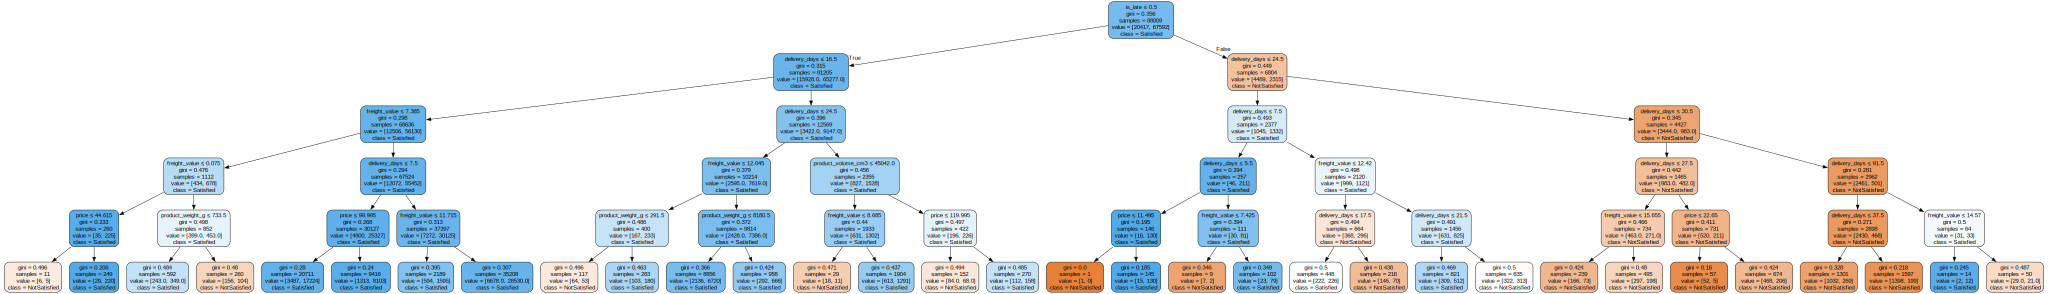

Saved tree visualization: decision_tree_baseline.pdf


In [10]:
# NHIỆM VỤ 1: Decision Tree (sklearn) + hiển thị Graphviz
# ============================
print("\n>> NHIỆM VỤ 1: Huấn luyện Decision Tree (sklearn) và vẽ bằng graphviz")

# 1.1 Tạo model baseline (có thể thay tham số nếu cần)
dt_baseline = DecisionTreeClassifier(max_depth=5, random_state=RND)
dt_baseline.fit(X_train_imp, y_train)

# 1.2 Đánh giá baseline trên test
y_pred_dt_base = dt_baseline.predict(X_test_imp)
y_proba_dt_base = dt_baseline.predict_proba(X_test_imp)[:,1] if hasattr(dt_baseline, "predict_proba") else None
print_metrics(y_test, y_pred_dt_base, y_proba_dt_base, label="Decision Tree (baseline)")

# 1.3 Xuất cây sang DOT và hiển thị bằng graphviz (yêu cầu graphviz hệ thống)
dot_data = export_graphviz(
    dt_baseline,
    out_file=None,
    feature_names=features,
    class_names=['NotSatisfied','Satisfied'],
    filled=True, rounded=True,
    special_characters=True
)
graph = graphviz.Source(dot_data)
# Hiển thị trong notebook
display(graph)

# (Nếu muốn lưu file .pdf hoặc .png)
graph.render("decision_tree_baseline", format="pdf", cleanup=True)
print("Saved tree visualization: decision_tree_baseline.pdf")


# GridSearchCV cho Decision Tree + vẽ ảnh hưởng max_depth


>> NHIỆM VỤ 2: GridSearchCV tối ưu Decision Tree và vẽ đánh giá tham số
Fitting 5 folds for each of 224 candidates, totalling 1120 fits
GridSearchCV hoàn thành trong 92.9s
Best params (DT): {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV F1 (DT): 0.8811018816977569

=== Metrics: Decision Tree (tuned) ===
Accuracy : 0.795
Precision: 0.7977
Recall   : 0.9822
F1-score : 0.8804
ROC AUC  : 0.6509

Classification report:
               precision    recall  f1-score   support

           0       0.75      0.18      0.28      5104
           1       0.80      0.98      0.88     16899

    accuracy                           0.80     22003
   macro avg       0.77      0.58      0.58     22003
weighted avg       0.79      0.80      0.74     22003



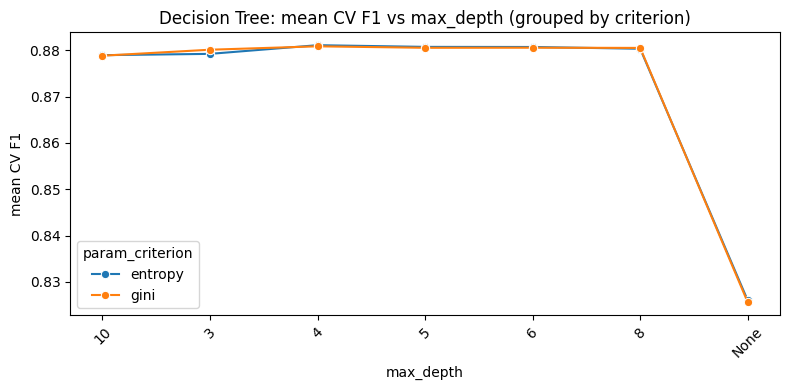

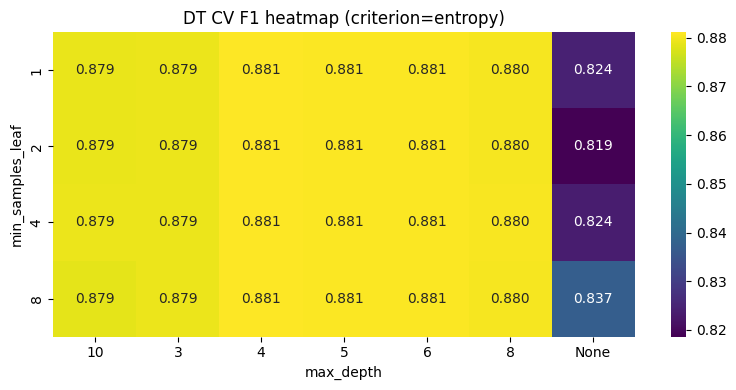

In [11]:
# NHIỆM VỤ 2: GridSearchCV cho Decision Tree + vẽ ảnh hưởng max_depth
# ============================
print("\n>> NHIỆM VỤ 2: GridSearchCV tối ưu Decision Tree và vẽ đánh giá tham số")

# 2.1 Grid param
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3,4,5,6,8,10,None],
    'min_samples_split': [2,5,10,20],
    'min_samples_leaf': [1,2,4,8]
}

grid_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=RND),
    param_grid=param_grid_dt,
    scoring='f1',   # ưu tiên f1 cho imbalance
    cv=5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

t0 = time.time()
grid_dt.fit(X_train_imp, y_train)
t1 = time.time()
print(f"GridSearchCV hoàn thành trong {t1-t0:.1f}s")
print("Best params (DT):", grid_dt.best_params_)
print("Best CV F1 (DT):", grid_dt.best_score_)

best_dt = grid_dt.best_estimator_

# 2.2 Đánh giá best_dt trên tập test
y_pred_dt = best_dt.predict(X_test_imp)
y_proba_dt = best_dt.predict_proba(X_test_imp)[:,1] if hasattr(best_dt,'predict_proba') else None
print_metrics(y_test, y_pred_dt, y_proba_dt, label="Decision Tree (tuned)")

# 2.3 Vẽ đồ thị: mean CV F1 vs max_depth (nhóm theo criterion)
res_dt = pd.DataFrame(grid_dt.cv_results_)
res_dt['param_max_depth_str'] = res_dt['param_max_depth'].astype(str)
agg = res_dt.groupby(['param_max_depth_str','param_criterion'])['mean_test_score'].mean().reset_index()

plt.figure(figsize=(8,4))
sns.lineplot(data=agg, x='param_max_depth_str', y='mean_test_score', hue='param_criterion', marker='o')
plt.title('Decision Tree: mean CV F1 vs max_depth (grouped by criterion)')
plt.xlabel('max_depth')
plt.ylabel('mean CV F1')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2.4 Heatmap: min_samples_leaf x max_depth cho criterion tốt nhất (trực quan)
best_crit = res_dt.loc[res_dt['mean_test_score'].idxmax(), 'param_criterion']
pivot = res_dt[res_dt['param_criterion']==best_crit].pivot_table(index='param_min_samples_leaf', columns='param_max_depth_str', values='mean_test_score')
plt.figure(figsize=(8,4))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis')
plt.title(f'DT CV F1 heatmap (criterion={best_crit})')
plt.xlabel('max_depth')
plt.ylabel('min_samples_leaf')
plt.tight_layout()
plt.show()

# Random Forest (build + tune + evaluate + plots)


>> NHIỆM VỤ 3: Random Forest - training, tuning, evaluate

=== Metrics: RandomForest (baseline) ===
Accuracy : 0.8241
Precision: 0.8414
Recall   : 0.9501
F1-score : 0.8924
ROC AUC  : 0.7507

Classification report:
               precision    recall  f1-score   support

           0       0.71      0.41      0.52      5104
           1       0.84      0.95      0.89     16899

    accuracy                           0.82     22003
   macro avg       0.78      0.68      0.71     22003
weighted avg       0.81      0.82      0.81     22003

Fitting 3 folds for each of 25 candidates, totalling 75 fits
RandomizedSearchCV hoàn tất trong 494.2s
Best params (RF): {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'gini'}
Best CV F1 (RF): 0.8912460084037407

=== Metrics: RandomForest (tuned) ===
Accuracy : 0.8248
Precision: 0.8355
Recall   : 0.9611
F1-score : 0.8939
ROC AUC  : 0.75

Classification report:
               precision    recall  f1-sc

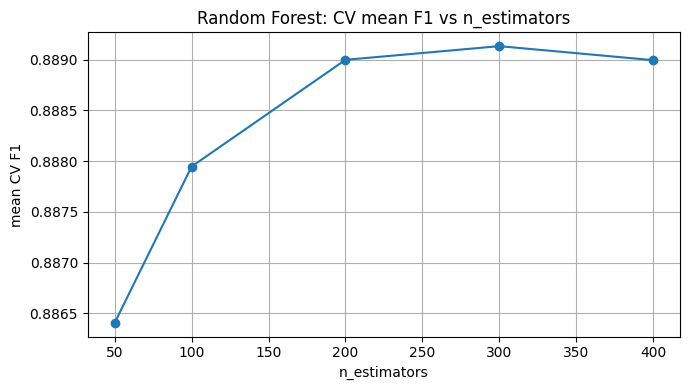


Best RF params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'gini'}


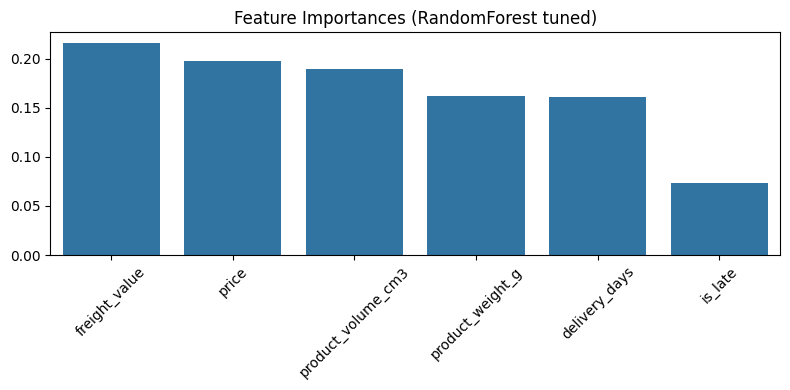

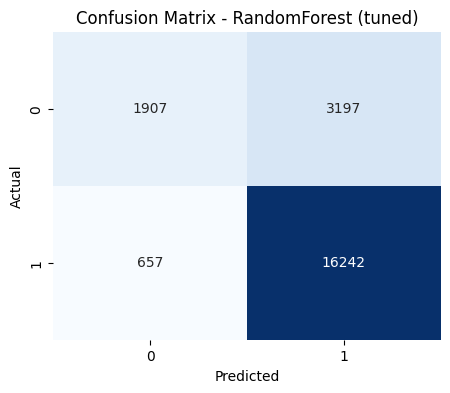

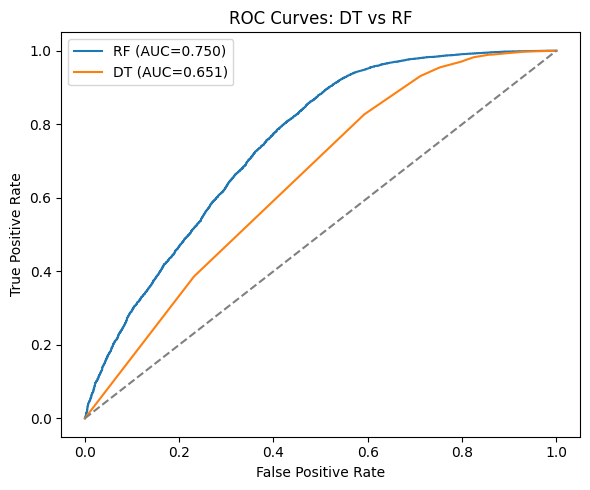

In [12]:
# NHIỆM VỤ 3: Random Forest (build + tune + evaluate + plots)
# ============================
print("\n>> NHIỆM VỤ 3: Random Forest - training, tuning, evaluate")

# 3.1 Tạo RandomForest mặc định & train (làm baseline)
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=RND, n_jobs=-1)
rf_baseline.fit(X_train_imp, y_train)
y_pred_rf_base = rf_baseline.predict(X_test_imp)
y_proba_rf_base = rf_baseline.predict_proba(X_test_imp)[:,1]
print_metrics(y_test, y_pred_rf_base, y_proba_rf_base, label="RandomForest (baseline)")

# 3.2 Tuning RandomForest: dùng RandomizedSearchCV (tốc độ) 
from scipy.stats import randint
param_dist_rf = {
    'n_estimators': [100,200,300,400],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'criterion': ['gini','entropy']
}

rand_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=RND, n_jobs=-1),
    param_distributions=param_dist_rf,
    n_iter=25,
    scoring='f1',
    cv=3,
    random_state=RND,
    n_jobs=-1,
    verbose=1
)

t0 = time.time()
rand_rf.fit(X_train_imp, y_train)
t1 = time.time()
print(f"RandomizedSearchCV hoàn tất trong {t1-t0:.1f}s")
print("Best params (RF):", rand_rf.best_params_)
print("Best CV F1 (RF):", rand_rf.best_score_)

best_rf = rand_rf.best_estimator_

# 3.3 Train lại best_rf (đảm bảo)
best_rf.fit(X_train_imp, y_train)

# 3.4 Đánh giá best_rf trên test
y_pred_rf = best_rf.predict(X_test_imp)
y_proba_rf = best_rf.predict_proba(X_test_imp)[:,1]
print_metrics(y_test, y_pred_rf, y_proba_rf, label="RandomForest (tuned)")

# 3.5 Vẽ biểu đồ: ảnh hưởng số cây n_estimators -> để làm được chính xác, ta có thể thử một loạt n_estimators và cross-val điểm
# (ở đây ta dùng nhanh: với các giá trị cố định, tính CV f1 bằng cross_val_score - hoặc dùng rand_rf.cv_results_)
vals = [50,100,200,300,400]
from sklearn.model_selection import cross_val_score
cv_scores = []
for n in vals:
    rf_temp = RandomForestClassifier(n_estimators=n, random_state=RND, n_jobs=-1)
    sc = cross_val_score(rf_temp, X_train_imp, y_train, cv=3, scoring='f1', n_jobs=-1)
    cv_scores.append(sc.mean())
plt.figure(figsize=(7,4))
plt.plot(vals, cv_scores, marker='o')
plt.title('Random Forest: CV mean F1 vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('mean CV F1')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3.6 Hiển thị tham số tốt nhất & feature importances
print("\nBest RF params:", rand_rf.best_params_)
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8,4))
sns.barplot(x=[features[i] for i in indices], y=importances[indices])
plt.xticks(rotation=45)
plt.title('Feature Importances (RandomForest tuned)')
plt.tight_layout()
plt.show()

# 3.7 Confusion matrix & ROC cho best_rf
plot_confusion(y_test, y_pred_rf, title="Confusion Matrix - RandomForest (tuned)")
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'RF (AUC={roc_auc_score(y_test, y_proba_rf):.3f})')
if y_proba_dt is not None:
    fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
    plt.plot(fpr_dt, tpr_dt, label=f'DT (AUC={roc_auc_score(y_test, y_proba_dt):.3f})')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves: DT vs RF')
plt.legend()
plt.tight_layout()
plt.show()


# Bảng so sánh tổng quát

In [13]:
# 8. Bảng so sánh tổng quát
print("\n=== SO SÁNH TỔNG QUAN TRÊN TẬP TEST ===")
print("Decision Tree (tuned): ACC", round(accuracy_score(y_test, y_pred_dt),4), 
      "F1", round(f1_score(y_test, y_pred_dt, zero_division=0),4))
print("Random Forest (tuned): ACC", round(accuracy_score(y_test, y_pred_rf),4), 
      "F1", round(f1_score(y_test, y_pred_rf, zero_division=0),4))


=== SO SÁNH TỔNG QUAN TRÊN TẬP TEST ===
Decision Tree (tuned): ACC 0.795 F1 0.8804
Random Forest (tuned): ACC 0.8248 F1 0.8939


In [14]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Before SMOTE:", Counter(y_train))

smote = SMOTE(random_state=RND)
X_train_sm, y_train_sm = smote.fit_resample(X_train_imp, y_train)

print("After SMOTE:", Counter(y_train_sm))


Before SMOTE: Counter({1: 67592, 0: 20417})
After SMOTE: Counter({0: 67592, 1: 67592})


In [15]:
# PHẦN 2 – TRAIN + TUNE RANDOM FOREST TRÊN DATA ĐÃ BALANCE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

param_dist = {
    'n_estimators': [100,200],
    'max_depth' : [None,10,20],
    'min_samples_split': [2,5],
    'min_samples_leaf': [1,2],
    'max_features': ['sqrt'],
    'class_weight': ['balanced']
}

rf_balanced = RandomForestClassifier(
    random_state=RND,
    n_jobs=2
)

rand_rf = RandomizedSearchCV(
    estimator=rf_balanced,
    param_distributions=param_dist,
    n_iter=12,
    scoring='f1',
    cv=3,
    random_state=RND,
    n_jobs=2,
    verbose=1
)

rand_rf.fit(X_train_sm, y_train_sm)

best_rf_balanced = rand_rf.best_estimator_

print("\nBest RF Balanced params:")
print(rand_rf.best_params_)

print("Best CV F1:")
print(rand_rf.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best RF Balanced params:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}
Best CV F1:
0.8672578730876156


In [16]:
# PHẦN 3 – ĐÁNH GIÁ MÔ HÌNH RF SAU XỬ LÝ IMBALANCE
from sklearn.metrics import classification_report, roc_auc_score

y_pred = best_rf_balanced.predict(X_test_imp)
y_proba = best_rf_balanced.predict_proba(X_test_imp)[:,1]

print_metrics(y_test, y_pred, y_proba, label="Random Forest (SMOTE + tuned)")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



=== Metrics: Random Forest (SMOTE + tuned) ===
Accuracy : 0.8108
Precision: 0.8435
Recall   : 0.9254
F1-score : 0.8825
ROC AUC  : 0.7482

Classification report:
               precision    recall  f1-score   support

           0       0.64      0.43      0.51      5104
           1       0.84      0.93      0.88     16899

    accuracy                           0.81     22003
   macro avg       0.74      0.68      0.70     22003
weighted avg       0.80      0.81      0.80     22003


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.43      0.51      5104
           1       0.84      0.93      0.88     16899

    accuracy                           0.81     22003
   macro avg       0.74      0.68      0.70     22003
weighted avg       0.80      0.81      0.80     22003



# 7 . So sánh mô hình & kết quả

In [17]:
import pandas as pd
from sklearn.metrics import classification_report
import numpy as np 


# BƯỚC 1: TẠO DỰ ĐOÁN CHO MÔ HÌNH RF (SMOTE + TUNED) 

try:
    # Dự đoán cho RF (SMOTE + TunED)
    y_pred_rf_smote_tuned = best_rf_balanced.predict(X_test_imp)
except NameError:
    print("Lỗi: Các biến 'X_test_imp', 'best_rf_balanced' hoặc 'y_test' chưa được định nghĩa.")
    exit() 
except Exception as e:
    print(f"Lỗi xảy ra khi dự đoán bằng best_rf_balanced: {e}")
    exit()

# BƯỚC 2: HÀM SO SÁNH VÀ HIỂN THỊ KẾT QUẢ 

def compare_rf_models(y_test, y_preds_dict):
    """
    Tạo DataFrame so sánh hiệu suất cho cả LỚP 0 và LỚP 1 giữa các mô hình RF.
    Bao gồm: Precision, Recall, F1 cho từng lớp + F1 weighted.
    """
    comparison = {}
    
    for name, y_pred in y_preds_dict.items():
        report = classification_report(
            y_test, y_pred,
            output_dict=True,
            zero_division=0
        )
        
        comparison[name] = {
            # ===== Tổng thể =====
            'F1-score Tổng thể (Weighted Avg)': report['weighted avg']['f1-score'],
            
            # ===== LỚP 0 (KHÔNG hài lòng ) =====
            'Precision Lớp 0': report['0']['precision'],
            'Recall Lớp 0 (Mục tiêu)': report['0']['recall'],
            'F1-score Lớp 0': report['0']['f1-score'],
            
            # ===== LỚP 1 (HÀI LÒNG) =====
            'Precision Lớp 1': report['1']['precision'],
            'Recall Lớp 1': report['1']['recall'],
            'F1-score Lớp 1': report['1']['f1-score']
        }
    
    df_comparison = pd.DataFrame(comparison).T

    # Sắp xếp theo Recall lớp 0 
    df_comparison = df_comparison.sort_values(
        by='Recall Lớp 0 (Mục tiêu)',
        ascending=False
    )
    
    return df_comparison.style.format({
        'F1-score Tổng thể (Weighted Avg)': "{:.4f}",
        'Precision Lớp 0': "{:.4f}",
        'Recall Lớp 0 (Mục tiêu)': "{:.4f}",
        'F1-score Lớp 0': "{:.4f}",
        'Precision Lớp 1': "{:.4f}",
        'Recall Lớp 1': "{:.4f}",
        'F1-score Lớp 1': "{:.4f}"
    })


# BƯỚC 3: THỰC HIỆN SO SÁNH

y_preds_to_compare = {
    "RF (SMOTE + Tuned)": y_pred_rf_smote_tuned,
    "RF (Đã Tune, Không SMOTE)": y_pred_rf,
    "RF (Baseline, Mặc định)": y_pred_rf_base
}

print("\n=== KẾT QUẢ SO SÁNH HIỆU SUẤT RF ===")

comparison_table = compare_rf_models(y_test, y_preds_to_compare)
print(comparison_table)


=== KẾT QUẢ SO SÁNH HIỆU SUẤT RF ===


In [18]:
comparison_table

,F1-score Tổng thể (Weighted Avg),Precision Lớp 0,Recall Lớp 0 (Mục tiêu),F1-score Lớp 0,Precision Lớp 1,Recall Lớp 1,F1-score Lớp 1
RF (SMOTE + Tuned),0.7971,0.6359,0.4314,0.5141,0.8435,0.9254,0.8825
"RF (Baseline, Mặc định)",0.8055,0.7111,0.4069,0.5176,0.8414,0.9501,0.8924
"RF (Đã Tune, Không SMOTE)",0.8020,0.7438,0.3736,0.4974,0.8355,0.9611,0.8939


# 8. Lưu mô hình & kết quả

In [19]:
joblib.dump(best_dt, "best_dt_model.pkl")
joblib.dump(best_rf, "best_rf_model.pkl")
joblib.dump(best_rf_balanced, "best_rf_model_balanced.pkl")
joblib.dump(rand_rf, "randsearch_rf.pkl")
joblib.dump(grid_dt, "gridsearch_dt.pkl")
print("Saved models & search objects.")

Saved models & search objects.


# Dự đoán dữ liệu nghiệp vụ

In [20]:
best_rf_balanced = joblib.load("best_rf_model_balanced.pkl")

In [21]:
def validate_user_input(data: dict):
    # Các biến không được âm
    for f in ['price', 'freight_value', 'delivery_days', 'product_weight_g']:
        if data[f] < 0:
            raise ValueError(f"{f} không được âm")

    # Biến nhị phân
    if data['is_late'] not in [0, 1]:
        raise ValueError("is_late chỉ nhận 0 hoặc 1")

    # Kích thước sản phẩm
    for dim in ['product_length_cm', 'product_width_cm', 'product_height_cm']:
        if not np.isnan(data[dim]) and data[dim] < 0:
            raise ValueError(f"{dim} không được âm")
     # Thêm điều kiện: Chiều dài phải lớn hơn chiều rộng (nếu cả hai đều có giá trị)
    if (not np.isnan(data['product_length_cm'])) and (not np.isnan(data['product_width_cm'])):
        if data['product_length_cm'] <= data['product_width_cm']:
            raise ValueError("Chiều dài sản phẩm (product_length_cm) phải lớn hơn chiều rộng (product_width_cm)")       


In [22]:
def get_user_input():
    def read_float(msg):
        val = input(msg)
        return float(val) if val.strip() != "" else np.nan

    return {
        'price': float(input("Giá sản phẩm: ")),
        'freight_value': float(input("Phí vận chuyển: ")),
        'delivery_days': int(input("Số ngày giao hàng: ")),
        'is_late': int(input("Giao trễ? (0 = Không, 1 = Có): ")),
        'product_weight_g': float(input("Khối lượng (gram): ")),
        'product_length_cm': read_float("Chiều dài (cm): "),
        'product_width_cm': read_float("Chiều rộng (cm): "),
        'product_height_cm': read_float("Chiều cao (cm): ")
    }


In [23]:
def predict_satisfaction(model):
    # Nhập dữ liệu
    data = get_user_input()

    # Kiểm tra hợp lệ
    validate_user_input(data)

    # Chuyển sang DataFrame
    df = pd.DataFrame([data])

    # TÍNH THỂ TÍCH SẢN PHẨM 
    df['product_volume_cm3'] = (
        df['product_length_cm'].fillna(0) *
        df['product_width_cm'].fillna(0) *
        df['product_height_cm'].fillna(0)
    )

    # Chọn feature 
    X = df[[
        'price',
        'freight_value',
        'delivery_days',
        'is_late',
        'product_weight_g',
        'product_volume_cm3'
    ]]

    # Dự đoán
    y_pred = model.predict(X)[0]
    y_proba = model.predict_proba(X)[0][1]

    return df, X, y_pred, y_proba


In [24]:
def show_result(df, X, y_pred, y_proba):
    print("\n=== KẾT QUẢ DỰ ĐOÁN ===")

    # Ngưỡng quyết định
    HIGH_THRESHOLD = 0.6
    LOW_THRESHOLD = 0.4

    if y_proba >= HIGH_THRESHOLD:
        print(f" Khách hàng HÀI LÒNG ({y_proba:.2%})")

    elif y_proba <= LOW_THRESHOLD:
        print(f" Khách hàng KHÔNG HÀI LÒNG ({y_proba:.2%})")

    else:
        print(f" Khách hàng KHÔNG CHẮC CHẮN ({y_proba:.2%})")
        print("  → Cần theo dõi thêm hoặc can thiệp nhẹ để cải thiện trải nghiệm")


In [28]:
print("===== NHẬP THÔNG TIN ĐƠN HÀNG =====")

df_user, X, y_pred, y_proba = predict_satisfaction(best_rf_balanced)

print("\n=== DỮ LIỆU ĐƠN HÀNG ===")
display(df_user)

show_result(df_user, X, y_pred, y_proba)


===== NHẬP THÔNG TIN ĐƠN HÀNG =====


Giá sản phẩm:  455
Phí vận chuyển:  22
Số ngày giao hàng:  4
Giao trễ? (0 = Không, 1 = Có):  1
Khối lượng (gram):  34245
Chiều dài (cm):  2345
Chiều rộng (cm):  22
Chiều cao (cm):  234



=== DỮ LIỆU ĐƠN HÀNG ===


,price,freight_value,delivery_days,is_late,product_weight_g,product_length_cm,product_width_cm,product_height_cm,product_volume_cm3
0,455.0,22.0,4,1,34245.0,2345.0,22.0,234.0,12072060.0



=== KẾT QUẢ DỰ ĐOÁN ===
 Khách hàng HÀI LÒNG (64.49%)


In [31]:
def show_comprehensive_result(model, X):
    # 1. Tạo explainer và tính toán SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)  

    # 2. Xử lý SHAP values đúng cách cho RandomForest (binary classification)
    if isinstance(shap_values, list):  
        shap_class_0 = shap_values[0]  
        shap_class_1 = shap_values[1]
    else: 
        shap_class_0 = shap_values[:, :, 0]
        shap_class_1 = shap_values[:, :, 1]

    # Vì chỉ có 1 sample, lấy hàng đầu tiên
    shap_0 = shap_class_0[0]
    shap_1 = shap_class_1[0]

    # 3. Tạo DataFrame kết quả
    df_shap_full = pd.DataFrame({
        'Feature': X.columns,
        'SHAP_Unhappy (Lớp 0)': shap_0,
        'SHAP_Happy (Lớp 1)': shap_1
    })
   
    # Sắp xếp theo mức độ ảnh hưởng tuyệt đối đến lớp Happy
    df_shap_full['abs_val'] = df_shap_full['SHAP_Happy (Lớp 1)'].abs()
    df_shap_full = df_shap_full.sort_values(by='abs_val', ascending=False).drop(columns='abs_val')
   
    return df_shap_full

In [32]:
import shap

# 1. Tính toán bảng SHAP
df_result = show_comprehensive_result(best_rf, X)

# 2. HIỂN THỊ KẾT QUẢ THEO ĐÚNG BỐ CỤC ẢNH
print("="*75)
status_text = "HÀI LÒNG" if y_proba >= 0.5 else "KHÔNG HÀI LÒNG"
print(f" KẾT QUẢ DỰ ĐOÁN: {status_text}")
print(f" Xác suất Hài lòng: {y_proba:.1%} | Không hài lòng: {1-y_proba:.1%}")
print("="*75)

# Hiển thị bảng SHAP định dạng số thập phân và ẩn index
display(df_result.style.format({
    'SHAP_Unhappy (Lớp 0)': '{:.6f}',
    'SHAP_Happy (Lớp 1)': '{:.6f}'
}).hide(axis='index'))

# 3. PHÂN TÍCH CHIẾN LƯỢC: HIỂN THỊ SONG SONG 2 LÝ DO
print("\n PHÂN TÍCH CHIẾN LƯỢC:")

# Tìm điểm mạnh nhất và điểm yếu nhất dựa trên SHAP của lớp Happy (Lớp 1)
best_feat = df_result.loc[df_result['SHAP_Happy (Lớp 1)'].idxmax(), 'Feature']
worst_feat = df_result.loc[df_result['SHAP_Happy (Lớp 1)'].idxmin(), 'Feature']

print(f" Khách hài lòng nhờ: {best_feat}!")
print(f" Lý do khách không hài lòng: {worst_feat}!")

 KẾT QUẢ DỰ ĐOÁN: HÀI LÒNG
 Xác suất Hài lòng: 64.5% | Không hài lòng: 35.5%


Feature,SHAP_Unhappy (Lớp 0),SHAP_Happy (Lớp 1)
delivery_days,-0.241326,0.241326
product_volume_cm3,0.076415,-0.076415
product_weight_g,0.051580,-0.051580
price,-0.026658,0.026658
is_late,-0.012789,0.012789
freight_value,0.007811,-0.007811



 PHÂN TÍCH CHIẾN LƯỢC:
 Khách hài lòng nhờ: delivery_days!
 Lý do khách không hài lòng: product_volume_cm3!
